### 0. Imports and requirements

In [16]:
%load_ext autoreload
%autoreload 2

import os
import pandas as pd
import sys
import pickle
import numpy as np
import torch
import torch.nn as nn
import os
import torch
from tqdm import trange


from sklearn.model_selection import train_test_split
import tqdm 


pd.set_option("display.max_columns", None)
sys.path.append('/kaggle/input/credit') # замени на свою
sys.path.append('../')



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8-whitegrid")

### 1. Data Preprocessing

In [18]:
import dataset_preprocessing_utils
print(dir(dataset_preprocessing_utils))

['Dict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_padded_buckets', 'features', 'np', 'pad_sequence', 'pd', 'pickle', 'tqdm', 'transform_credits_to_sequences', 'truncate']


In [19]:
# тут тоже поставь свое 
TRAIN_DATA_PATH = "/kaggle/input/credit/data/train_data/" 
TEST_DATA_PATH = "/kaggle/input/credit/data/test_data/"

TRAIN_TARGET_PATH = "/kaggle/input/credit/data/train_target.csv"

In [20]:
train_target = pd.read_csv(TRAIN_TARGET_PATH)

In [21]:
from utils import read_parquet_dataset_from_local
from dataset_preprocessing_utils import features, transform_credits_to_sequences, create_padded_buckets

* В дальнейшем при построении рекуррентной нейронной сети нам понадобятся следующие статистики по тренировочной и тестовой выборкам: распределение длин кредитных историй и число уникальных значений каждого категориального значения. Посчитаем эти статистики:

In [22]:
%%time
from collections import defaultdict


train_lens = []
test_lens = []
uniques = defaultdict(set)

for step in tqdm.notebook.tqdm(range(0, 12, 4),
                     desc="Count statistics on train data"):
        credits_frame = read_parquet_dataset_from_local(TRAIN_DATA_PATH, step, 4, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        train_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
train_lens = np.hstack(train_lens)

for step in tqdm.notebook.tqdm(range(0, 2, 2),
                     desc="Count statistics on test data"):
        credits_frame = read_parquet_dataset_from_local(TEST_DATA_PATH, step, 2, verbose=True)
        seq_lens = credits_frame.groupby("id").agg(seq_len=("rn", "max"))["seq_len"].values
        test_lens.extend(seq_lens)
        credits_frame.drop(columns=["id", "rn"], inplace=True)
        for feat in credits_frame.columns.values:
            uniques[feat] = uniques[feat].union(credits_frame[feat].unique())
test_lens = np.hstack(test_lens)
uniques = dict(uniques)

Count statistics on train data:   0%|          | 0/3 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq
/kaggle/input/credit/data/train_data/train_data_3.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_8.pq
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/4 [00:00<?, ?it/s]

Count statistics on test data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/test_data/test_data_0.pq
/kaggle/input/credit/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

CPU times: user 46.3 s, sys: 34.1 s, total: 1min 20s
Wall time: 46.8 s


* Чтобы сразу убедиться, что посчитанные статистики интересные и полезные, построим графики распределений длин кредитных историй в тренировочной и тестовой выборках

In [23]:
import dataset_preprocessing_utils
print(dir(dataset_preprocessing_utils))

['Dict', '__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__spec__', 'create_padded_buckets', 'features', 'np', 'pad_sequence', 'pd', 'pickle', 'tqdm', 'transform_credits_to_sequences', 'truncate']


In [24]:
from collections import Counter


train_len_counter = pd.Series(Counter(train_lens)).sort_index()
test_len_counter = pd.Series(Counter(test_lens)).sort_index()

<BarContainer object of 54 artists>

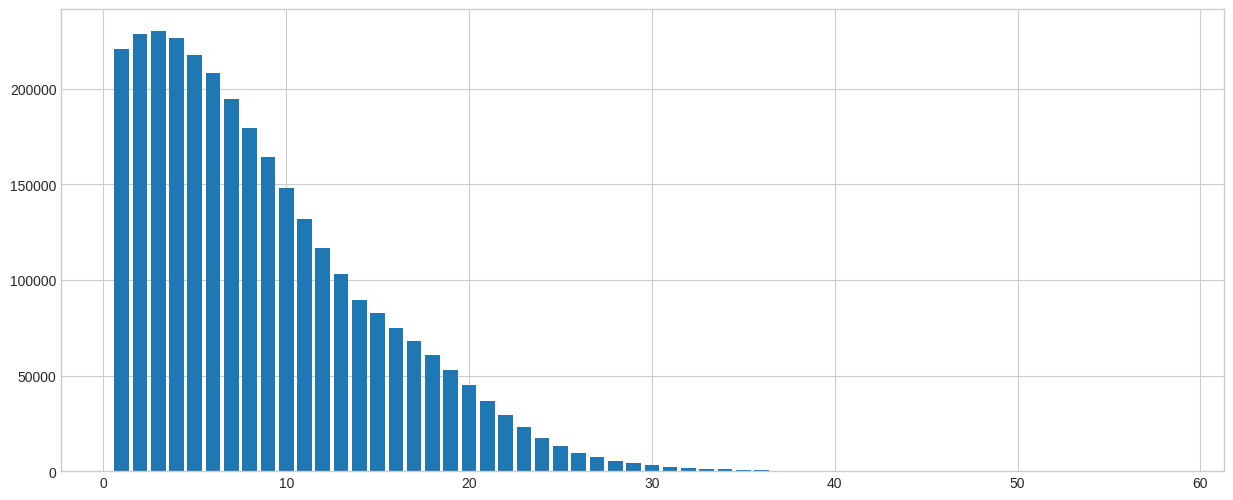

In [25]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(train_len_counter.index.values, train_len_counter.values)

<BarContainer object of 50 artists>

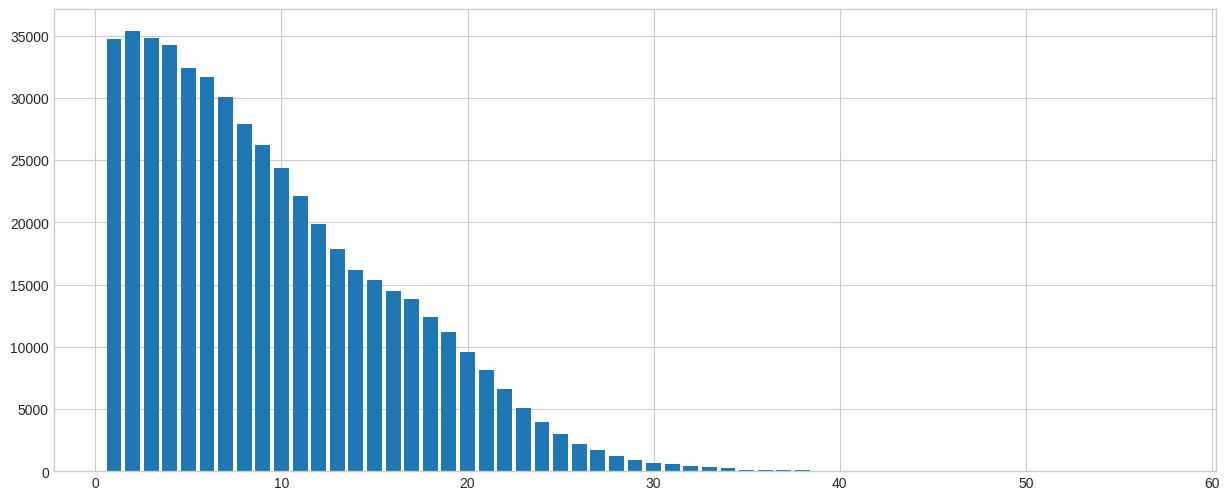

In [26]:
fig, ax = plt.subplots(figsize=(15, 6), nrows=1)
ax.bar(test_len_counter.index.values, test_len_counter.values)

In [27]:
train_lens.max(), test_lens.max()

(58, 57)

* Один из аргументов в функции `dataset_preprocessing_utils.create_padded_buckets` &ndash; `bucket_info` &ndash; словарь, где для конкретной длины последовательности указано до какой длины нужно делать паддинг. Для данного бэйзлайна возьмем простое разбиение на 43 бакета: 
| Длина последовательности | Длина после паддинга |
| :-: | :-: 
| 1 &ndash; 40 | без изменений |
| 41 &ndash; 45 | 45 |
| 46 &ndash; 50 | 50 |
| 51 &ndash; 58 | 58 |

In [28]:
keys_ = list(range(1, 59)) 
lens_ = list(range(1, 41)) + [45] * 5 + [50] * 5 + [58] * 8
bucket_info = dict(zip(keys_, lens_))
bucket_info

{1: 1,
 2: 2,
 3: 3,
 4: 4,
 5: 5,
 6: 6,
 7: 7,
 8: 8,
 9: 9,
 10: 10,
 11: 11,
 12: 12,
 13: 13,
 14: 14,
 15: 15,
 16: 16,
 17: 17,
 18: 18,
 19: 19,
 20: 20,
 21: 21,
 22: 22,
 23: 23,
 24: 24,
 25: 25,
 26: 26,
 27: 27,
 28: 28,
 29: 29,
 30: 30,
 31: 31,
 32: 32,
 33: 33,
 34: 34,
 35: 35,
 36: 36,
 37: 37,
 38: 38,
 39: 39,
 40: 40,
 41: 45,
 42: 45,
 43: 45,
 44: 45,
 45: 45,
 46: 50,
 47: 50,
 48: 50,
 49: 50,
 50: 50,
 51: 58,
 52: 58,
 53: 58,
 54: 58,
 55: 58,
 56: 58,
 57: 58,
 58: 58}

* Так же рассмотрим уникальные значения признаков

In [29]:
for feat, uniq in uniques.items():
    print(f"Feature: {feat}, unique values: {uniq}")

Feature: pre_since_opened, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_since_confirmed, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_pterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17}
Feature: pre_fterm, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_pclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16}
Feature: pre_till_fclose, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15}
Feature: pre_loans_credit_limit, unique values: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Feature: pre_loans_next_pay_summ, unique values: {0, 1, 2, 3, 4, 5, 6, 7}
Feature: pre_loans_outstanding, unique values: {1, 2, 3, 4, 5}
Feature: pre_loans_total_overdue, unique values: {0, 1}
Feature: pre_loans_max_overdue_sum, unique values: {0, 1, 2, 3}
Feature: pre_lo

* Поскольку паддинг будет производиться нулями, а категориальные признаки закодированы, начиная с 0, перед паддингом будем сдвигать все значения на 1.

* Вся описанная выше предобработка данных реализована в виде функции `create_buckets_from_credits`:

In [30]:
def create_buckets_from_credits(path_to_dataset, bucket_info, save_to_path, frame_with_ids = None, 
                                num_parts_to_preprocess_at_once: int = 1, 
                                num_parts_total=50, has_target=False):
    block = 0
    for step in tqdm.notebook.tqdm(range(0, num_parts_total, num_parts_to_preprocess_at_once),
                     desc="Preparing credit data"):
        credits_frame = read_parquet_dataset_from_local(path_to_dataset, step, num_parts_to_preprocess_at_once, verbose=True)
        credits_frame.loc[:, features] += 1       
        seq = transform_credits_to_sequences(credits_frame)
        print("Transforming credits to sequences is done.")
        
        if frame_with_ids is not None:
            seq = seq.merge(frame_with_ids, on="id")

        block_as_str = str(block)
        if len(block_as_str) == 1:
            block_as_str = "00" + block_as_str
        else:
            block_as_str = "0" + block_as_str
            
        processed_fragment =  create_padded_buckets(seq, bucket_info=bucket_info, has_target=has_target, 
                                                    save_to_file_path=os.path.join(save_to_path, 
                                                                                   f"processed_chunk_{block_as_str}.pkl"))
        block += 1

* Разобьем обучающие данные на тренировочную и валидационную выборки. Воспользуемся самым простым способом &ndash; для валидации случайным образом выберем 10% обучающих данных.

In [31]:
train, val = train_test_split(train_target, random_state=42, test_size=0.1)
train.shape, val.shape

((2700000, 2), (300000, 2))

In [32]:
TRAIN_BUCKETS_PATH = "data/train_buckets_rnn"
VAL_BUCKETS_PATH = "data/val_buckets_rnn"
TEST_BUCKETS_PATH = "data/test_buckets_rnn"

In [33]:
import shutil

for buckets_path in [TRAIN_BUCKETS_PATH, VAL_BUCKETS_PATH, TEST_BUCKETS_PATH]:
    if os.path.exists(buckets_path):
        print(f"Удаляю папку {buckets_path}")
        shutil.rmtree(buckets_path)  # Удаляем директорию и её содержимое
    print(f"Создаю папку {buckets_path}")
    os.makedirs(buckets_path)  # Создаём директорию

Создаю папку data/train_buckets_rnn
Создаю папку data/val_buckets_rnn
Создаю папку data/test_buckets_rnn


In [34]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TRAIN_BUCKETS_PATH,
                            frame_with_ids=train,
                            num_parts_to_preprocess_at_once=3, 
                            num_parts_total=12, has_target=True)

dataset_train = sorted([os.path.join(TRAIN_BUCKETS_PATH, x) for x in os.listdir(TRAIN_BUCKETS_PATH)])
dataset_train

Preparing credit data:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_3.pq
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq
/kaggle/input/credit/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/42 [00:00<?, ?it/s]

CPU times: user 9min 36s, sys: 1min 16s, total: 10min 52s
Wall time: 10min 20s


['data/train_buckets_rnn/processed_chunk_000.pkl',
 'data/train_buckets_rnn/processed_chunk_001.pkl',
 'data/train_buckets_rnn/processed_chunk_002.pkl',
 'data/train_buckets_rnn/processed_chunk_003.pkl']

In [35]:
%%time
create_buckets_from_credits(TRAIN_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=VAL_BUCKETS_PATH,
                            frame_with_ids=val,
                            num_parts_to_preprocess_at_once=3, 
                            num_parts_total=12, has_target=True)

dataset_val = sorted([os.path.join(VAL_BUCKETS_PATH, x) for x in os.listdir(VAL_BUCKETS_PATH)])
dataset_val

Preparing credit data:   0%|          | 0/4 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_0.pq
/kaggle/input/credit/data/train_data/train_data_1.pq
/kaggle/input/credit/data/train_data/train_data_2.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_3.pq
/kaggle/input/credit/data/train_data/train_data_4.pq
/kaggle/input/credit/data/train_data/train_data_5.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_6.pq
/kaggle/input/credit/data/train_data/train_data_7.pq
/kaggle/input/credit/data/train_data/train_data_8.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/41 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/train_data/train_data_9.pq
/kaggle/input/credit/data/train_data/train_data_10.pq
/kaggle/input/credit/data/train_data/train_data_11.pq


Reading dataset with pandas:   0%|          | 0/3 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 9min 7s, sys: 47.1 s, total: 9min 54s
Wall time: 9min 19s


['data/val_buckets_rnn/processed_chunk_000.pkl',
 'data/val_buckets_rnn/processed_chunk_001.pkl',
 'data/val_buckets_rnn/processed_chunk_002.pkl',
 'data/val_buckets_rnn/processed_chunk_003.pkl']

In [36]:
%%time
create_buckets_from_credits(TEST_DATA_PATH,
                            bucket_info=bucket_info,
                            save_to_path=TEST_BUCKETS_PATH, num_parts_to_preprocess_at_once=2, 
                            num_parts_total=2)

dataset_test = sorted([os.path.join(TEST_BUCKETS_PATH, x) for x in os.listdir(TEST_BUCKETS_PATH)])
dataset_test

Preparing credit data:   0%|          | 0/1 [00:00<?, ?it/s]

Reading chunks:
/kaggle/input/credit/data/test_data/test_data_0.pq
/kaggle/input/credit/data/test_data/test_data_1.pq


Reading dataset with pandas:   0%|          | 0/2 [00:00<?, ?it/s]

Transforming credits to sequences is done.


Extracting buckets:   0%|          | 0/43 [00:00<?, ?it/s]

CPU times: user 1min 36s, sys: 12.1 s, total: 1min 48s
Wall time: 1min 42s


['data/test_buckets_rnn/processed_chunk_000.pkl']

### 2. Modeling

In [37]:
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
elif torch.backends.mps.is_available():
    device = torch.device("mps")
print('Using device:', device)

Using device: cuda


* Для создания модели будем использовать фреймворк `torch`. В нем есть все, чтобы писать произвольные сложные архитектуры и быстро экспериментировать. Для того, чтобы мониторить и логировать весь процесс во время обучения сетей, рекомендуется использовать надстройки над данным фреймворком, например, `lightning`.

* В бейзлайне мы предлагаем базовые компоненты, чтобы можно было обучать нейронную сеть и отслеживать ее качество. Для этого вам предоставлены следующие функции:
    * `data_generators.batches_generator` &ndash; функция-генератор, итеративно возвращает батчи, поддерживает батчи для `tensorflow.keras` и `torch.nn.Module` моделей. В зависимости от флага `is_train` может быть использована для генерации батчей на train/val/test стадии.
    * функция `pytorch_training.train_epoch` &ndash; обучает модель одну эпоху.
    * функция `pytorch_training.eval_model` &ndash; проверяет качество модели на отложенной выборке и возвращает roc_auc_score.
    * функция `pytorch_training.inference` &ndash; делает предикты на новых данных и готовит фрейм для проверяющей системы.
    * класс `training_aux.EarlyStopping` &ndash; реализует early_stopping, сохраняя лучшую модель. Пример использования приведен ниже.

In [38]:
from data_generators import batches_generator
from pytorch_training import train_epoch, eval_model, inference
from training_aux import EarlyStopping

* Все признаки, описывающие кредитную историю клиентов &ndash; категориальные. Для их представления в модели используем категориальные эмбеддинги. Для этого нужно каждому категориальному признаку задать размерность латентного пространства. Используем [формулу](https://forums.fast.ai/t/size-of-embedding-for-categorical-variables/42608) из библиотеки `fast.ai`.

In [39]:
def compute_embed_dim(n_cat: int) -> int:
    return min(600, round(1.6 * n_cat**0.56))

In [40]:
embedding_projections = {feat: (max(uniq)+1, compute_embed_dim(max(uniq)+1)) for feat, uniq in uniques.items()}
embedding_projections

{'pre_since_opened': (20, 9),
 'pre_since_confirmed': (18, 8),
 'pre_pterm': (18, 8),
 'pre_fterm': (17, 8),
 'pre_till_pclose': (17, 8),
 'pre_till_fclose': (16, 8),
 'pre_loans_credit_limit': (20, 9),
 'pre_loans_next_pay_summ': (8, 5),
 'pre_loans_outstanding': (6, 4),
 'pre_loans_total_overdue': (2, 2),
 'pre_loans_max_overdue_sum': (4, 3),
 'pre_loans_credit_cost_rate': (14, 7),
 'pre_loans5': (18, 8),
 'pre_loans530': (20, 9),
 'pre_loans3060': (10, 6),
 'pre_loans6090': (6, 4),
 'pre_loans90': (20, 9),
 'is_zero_loans5': (2, 2),
 'is_zero_loans530': (2, 2),
 'is_zero_loans3060': (2, 2),
 'is_zero_loans6090': (2, 2),
 'is_zero_loans90': (2, 2),
 'pre_util': (20, 9),
 'pre_over2limit': (20, 9),
 'pre_maxover2limit': (20, 9),
 'is_zero_util': (2, 2),
 'is_zero_over2limit': (2, 2),
 'is_zero_maxover2limit': (2, 2),
 'enc_paym_0': (4, 3),
 'enc_paym_1': (4, 3),
 'enc_paym_2': (4, 3),
 'enc_paym_3': (4, 3),
 'enc_paym_4': (4, 3),
 'enc_paym_5': (4, 3),
 'enc_paym_6': (4, 3),
 'enc_pay

* Реализуем модель. Все входные признаки представим в виде эмбеддингов, сконкатенируем, чтобы получить векторное представление транзакции. Подадим последовательности в `GRU` рекуррентный слой. Используем последнее скрытое состояние в качестве выхода слоя. На основе такого входа построим небольшой `MLP`, выступающий классификатором для целевой задачи. Используем градиентный спуск, чтобы решить оптимизационную задачу.

In [41]:
class RNN_GRU(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32, bidirectional=False, num_layers=1, dropout = 0.0):
        super(CreditsRNN, self).__init__()
       
        self._credits_cat_embeddings = nn.ModuleList([
            self._create_embedding_projection(*embedding_projections[feature])
            for feature in features
        ])
        input_size = sum([embedding_projections[x][1] for x in features])
        self._gru = nn.GRU(input_size=sum([embedding_projections[x][1] for x in features]),
                            hidden_size=rnn_units,
                            batch_first=True,
                            bidirectional=bidirectional,
                            num_layers=num_layers,
                            dropout = dropout)
        self._hidden_size = rnn_units * (2 if bidirectional else 1)
        self._top_classifier = nn.Linear(in_features=self._hidden_size, out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
        
    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        
        _, last_hidden = self._gru(concated_embeddings)
        hidden = hidden.permute(1, 2, 0)
        hidden = torch.reshape(hidden, (batch_size, self._hidden_size))
        
        classification_hidden = self._top_classifier(hidden)
        activation = self._intermediate_activation(classification_hidden)
        raw_output = self._head(activation)
        return raw_output
        
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality + add_missing, embedding_dim=embed_size, padding_idx=padding_idx)


In [60]:
class RNN_LSTM(nn.Module):
    def __init__(self, features, embedding_projections, rnn_units=128, top_classifier_units=32, bidirectional=False, num_layers=1, dropout = 0.0):
        super(CreditsRNN, self).__init__()
       
        self._credits_cat_embeddings = nn.ModuleList([
            self._create_embedding_projection(*embedding_projections[feature])
            for feature in features
        ])
        input_size = sum([embedding_projections[x][1] for x in features])
        self._lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=rnn_units,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=num_layers,
            dropout = dropout
        )
        
        self._hidden_size = rnn_units * (2 if bidirectional else 1)
        self._top_classifier = nn.Linear(in_features=self._hidden_size, out_features=top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(in_features=top_classifier_units, out_features=1)
        
    def forward(self, features):
        batch_size = features[0].shape[0]
        embeddings = [embedding(features[i]) for i, embedding in enumerate(self._credits_cat_embeddings)]
        concated_embeddings = torch.cat(embeddings, dim=-1)
        
        _, (hidden, _) = self._lstm(concated_embeddings)
        hidden = hidden.permute(1, 2, 0)
        hidden = torch.reshape(hidden, (batch_size, self._hidden_size))
        
        classification_hidden = self._top_classifier(hidden)
        activation = self._intermediate_activation(classification_hidden)
        raw_output = self._head(activation)
        return raw_output
        
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size, add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(num_embeddings=cardinality + add_missing, embedding_dim=embed_size, padding_idx=padding_idx)


In [62]:
class RNN_RNN(nn.Module):
    def __init__(self, features, embedding_projections,
                 rnn_units=128, top_classifier_units=32,
                 bidirectional=False, num_layers=1, dropout = 0.0):
        super(RNN_RNN, self).__init__()
       
        # Проекции эмбеддингов для категориальных признаков
        self._credits_cat_embeddings = nn.ModuleList([
            self._create_embedding_projection(*embedding_projections[feature])
            for feature in features
        ])
        
        # Размер входа в RNN — сумма всех размеров эмбеддингов
        input_size = sum(embedding_projections[x][1] for x in features)
        
        # RNN вместо LSTM
        self._rnn = nn.RNN(
            input_size=input_size,
            hidden_size=rnn_units,
            batch_first=True,
            bidirectional=bidirectional,
            num_layers=num_layers,
            dropout = dropout
        )
        
        # Итоговый размер скрытого состояния (учитываем направление)
        self._hidden_size = rnn_units * (2 if bidirectional else 1)
        
        # Верхний классификатор
        self._top_classifier = nn.Linear(self._hidden_size, top_classifier_units)
        self._intermediate_activation = nn.ReLU()
        self._head = nn.Linear(top_classifier_units, 1)
        
    def forward(self, features):
        # features — список тензоров [batch, seq_len] по каждому категориальному фичеру
        batch_size = features[0].shape[0]
        
        # Собираем эмбеддинги и конкатенируем по последнему измерению
        embeds = [emb(features[i]) for i, emb in enumerate(self._credits_cat_embeddings)]
        x = torch.cat(embeds, dim=-1)  # [batch, seq_len, input_size]
        
        # Прогоняем через RNN
        # output: [batch, seq_len, hidden_size * num_directions]
        # hidden: [num_layers * num_directions, batch, hidden_size]
        _, hidden = self._rnn(x)
        
        # Переставляем оси и разворачиваем скрытое состояние
        hidden = hidden.permute(1, 2, 0)            # [batch, hidden_size * num_directions, num_layers]
        hidden = hidden.reshape(batch_size, self._hidden_size)
        
        # Классификатор
        h = self._top_classifier(hidden)
        h = self._intermediate_activation(h)
        out = self._head(h)
        return out
        
    @classmethod
    def _create_embedding_projection(cls, cardinality, embed_size,
                                     add_missing=True, padding_idx=0):
        add_missing = 1 if add_missing else 0
        return nn.Embedding(
            num_embeddings=cardinality + add_missing,
            embedding_dim=embed_size,
            padding_idx=padding_idx
        )


### 3. Training

In [63]:
shutil.rmtree('./checkpoints/', ignore_errors=True)
os.makedirs('./checkpoints/', exist_ok=True)

* Запустим цикл обучения, каждую эпоху будем логировать лосс, а так же ROC-AUC на валидации и на обучении. Будем сохрнаять веса после каждой эпохи, а так же лучшие с помощью early_stopping.

In [66]:

def train_model(model, optimizer, dataset_train, dataset_val, num_epochs, 
                train_batch_size, val_batch_size, path_to_checkpoints, es, device):
    """
    Обучает модель, отслеживая значения ROC AUC для тренировки и валидации.

    Возвращает:
      best_model_path (str): путь к лучшей модели по валидационному ROC AUC.
      best_roc_auc (float): наилучшее значение ROC AUC на валидационной выборке.
      train_roc_auc_list (list): список ROC AUC на тренировке по эпохам.
      val_roc_auc_list (list): список ROC AUC на валидации по эпохам.
    """
    best_roc_auc = -float("inf")
    best_model_path = None
    train_roc_auc_list = []
    val_roc_auc_list = []
    
    for epoch in trange(num_epochs, desc="Training Epochs", unit="epoch", leave=True):
        # Обучаем модель на тренировочном датасете
        train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
                    shuffle=True, print_loss_every_n_batches=500, device=device)
        
        # Оцениваем модель на валидационном датасете
        current_val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
        val_roc_auc_list.append(current_val_roc_auc)
        
        # Оцениваем модель на тренировочном датасете (для контроля переобучения)
        current_train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
        train_roc_auc_list.append(current_train_roc_auc)
        
        #print(f"Epoch {epoch+1} completed. Train ROC AUC: {current_train_roc_auc}, Val ROC AUC: {current_val_roc_auc}")
       
        es(current_val_roc_auc, model)
        if es.early_stop:
            print("Early stopping reached. Stop training...")
            break
        
        # Сохраняем чекпоинт текущей эпохи (для истории)
        checkpoint_path = os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{current_val_roc_auc:.3f}.pt")
        torch.save(model.state_dict(), checkpoint_path)
    
    #print(f"Training finished. Best model saved at: {best_model_path} with Val ROC AUC: {best_roc_auc}")
    
    return best_model_path, best_roc_auc, train_roc_auc_list, val_roc_auc_list


In [ ]:
experiment_configs = [
    {
        "name": "exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_RNN_adam_lr_001_rnn_units64_tpu32_bd0",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_RNN_adam_lr_001_rnn_units128_tpu32_bd1",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0_dp2",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.2
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_RNN_adam_lr_001_rnn_units128_tpu32_bd0_dp5",
        "model_name": RNN_RNN,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 128,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp2_nl1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.2
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_GRU_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_GRU_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl1",
        "model_name": RNN_GRU,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd0_dp0_nl1",
        "model_name": RNN_LSTM,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": False,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp0_nl1",
        "model_name": RNN_LSTM,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "dropout":0.0
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl1",
        "model_name": RNN_LSTM,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 1,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    {
        "name": "exp_LSTM_adam_lr_001_rnn_units64_tpu32_bd1_dp5_nl2",
        "model_name": RNN_LSTM,  
        "optimizer": "adam",
        "optimizer_params": {
             "lr": 0.001,
            },
        "num_epochs": 20,
        "train_batch_size": 128,
        "val_batch_size": 128,
        "model_params": {
            "features":features,
            "embedding_projections": embedding_projections,
            "rnn_units": 64,
            "top_classifier_units": 32,
            "bidirectional": True,
            "num_layers": 2,
            "dropout":0.5
            },
        "early_stopping_patience": 3
    },
    
    
]

In [ ]:
print(len(experiment_configs))

In [ ]:
experiment_results = []

for config in tqdm.tqdm(experiment_configs, desc="Experiments", unit="experiment"):
    print(f"\n{'='*40}\nStarting experiment: {config['name']}")
    
    checkpoint_dir = os.path.join("checkpoints", config["name"])
    os.makedirs(checkpoint_dir, exist_ok=True)
    
    # Создание модели через передачу класса
    model = config["model_name"](**config["model_params"])
    model.to(device)
    
    # Настройка оптимизатора
    optimizer_name = config["optimizer"].lower()
    if optimizer_name == "adam":
        optimizer = torch.optim.Adam(model.parameters(),**config["optimizer_params"])
    elif optimizer_name == "sgd":
        optimizer = torch.optim.SGD(model.parameters(),**config["optimizer_params"])
    elif optimizer_name == 'adamw':
        optimizer = torch.optim.AdamW(model.parameters(),**config["optimizer_params"])
    else:
        raise ValueError(f"Неизвестный оптимизатор: {config['optimizer']}")
    
    # Создание объекта ранней остановки
    es = EarlyStopping(patience=config.get("early_stopping_patience", 3), verbose=False)
    
    # Запуск обучения
    best_model_path, best_roc_auc, train_roc_auc_list, val_roc_auc_list = train_model(
        model=model,
        optimizer=optimizer,
        dataset_train=dataset_train,
        dataset_val=dataset_val,
        num_epochs=config["num_epochs"],
        train_batch_size=config["train_batch_size"],
        val_batch_size=config["val_batch_size"],
        path_to_checkpoints=checkpoint_dir,
        es=es,
        device=device
    )
    
    print(f"Experiment {config['name']} finished. Best model saved at: {best_model_path}")
    
    experiment_results.append({
        "experiment": config["name"],
        "model_name": config["model_name"].__name__,  # Получаем имя класса модели
        "optimizer": config["optimizer"],
        "optimizer_params": config["optimizer_params"],
        "num_epochs": config["num_epochs"],
        "train_batch_size": config["train_batch_size"],
        "val_batch_size": config["val_batch_size"],
        "model_params": config["model_params"],
        "early_stopping_patience": config.get("early_stopping_patience", 3),
        "best_model_path": best_model_path,
        "best_roc_auc": best_roc_auc,
        "train_roc_auc": train_roc_auc_list,
        "val_roc_auc": val_roc_auc_list,
    })



Experiments:   0%|          | 0/1 [00:00<?, ?experiment/s]


Starting experiment: exp_RCNN_adam_lr_0.001_hidden128_layers2



Training Epochs:   0%|          | 0/1 [00:00<?, ?epoch/s]

Training: 0it [00:00, ?it/s]

In [ ]:
# --- Сохранение результатов в DataFrame ---
df_results = pd.DataFrame(experiment_results)
df_results

In [ ]:
df.to_csv('experiments_relults.csv', index=False, encoding='utf-8')

In [ ]:
%%time
for epoch in range(num_epochs):
    print(f"Starting epoch {epoch+1}")
    train_epoch(model, optimizer, dataset_train, batch_size=train_batch_size, 
                shuffle=True, print_loss_every_n_batches=500, device=device)
    
    val_roc_auc = eval_model(model, dataset_val, batch_size=val_batch_size, device=device)
    es(val_roc_auc, model)
    
    if es.early_stop:
        print("Early stopping reached. Stop training...")
        break
    torch.save(model.state_dict(), os.path.join(path_to_checkpoints, f"epoch_{epoch+1}_val_{val_roc_auc:.3f}.pt"))
    
    train_roc_auc = eval_model(model, dataset_train, batch_size=val_batch_size, device=device)
    print(f"Epoch {epoch+1} completed. Train ROC AUC: {train_roc_auc}, val ROC AUC: {val_roc_auc}")